# Isolation Forest Introduction

Anomalies are more susceptible to
isolation and hence have short path lengths.
Given a Gaussian distribution (135 points),
(a) a normal point xi requires twelve random
partitions to be isolated; (b) an anomaly xo requires only four partitions to be isolated. (c)
averaged path lengths of xi and xo converge
when the number of trees increases.

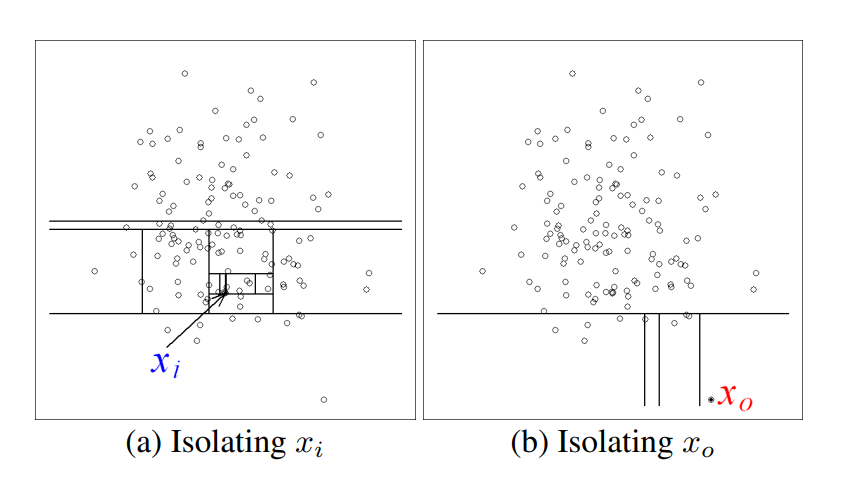

Using 1000 trees, the average path lengths of xo
and xi converge to 4.02 and 12.82 respectively. It shows
that anomalies are having path lengths shorter than normal
instances

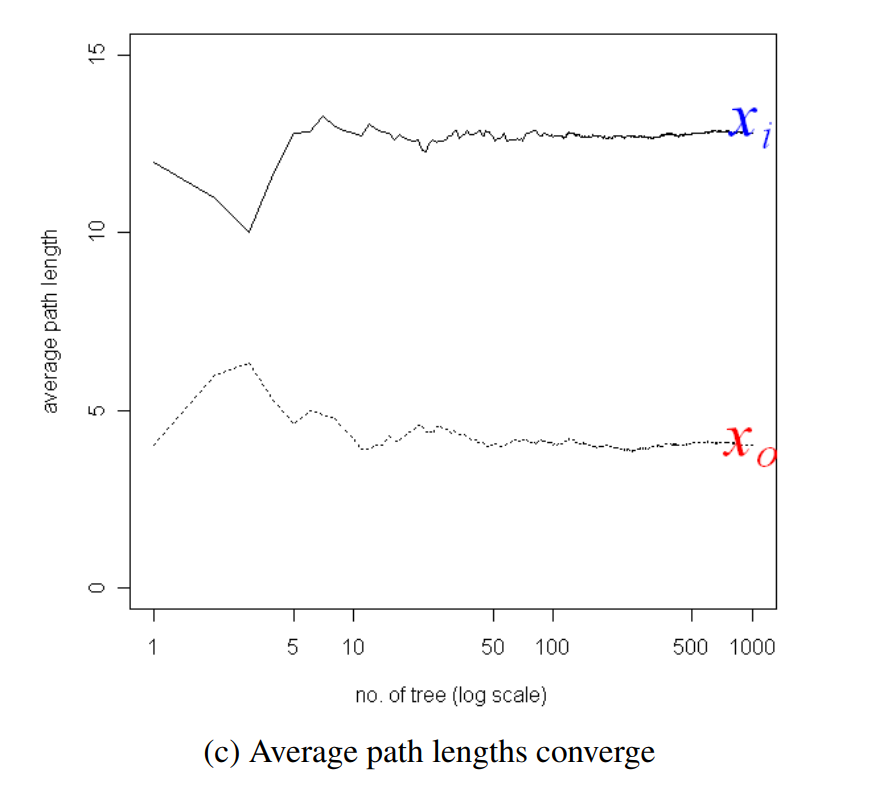

# Load Libraries

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Define Functions

In [191]:
# functions:

def remove_columns(df, cols):
  """
  This function removes columns from a pandas dataframe.

  Args:
      df: The pandas dataframe to remove columns from.
      cols: A list of column names to remove.

  Returns:
      A new pandas dataframe with the specified columns removed.
  """
  return df[list(set(df.columns) - set(cols))]





def scale_dataframe(df):
    """
    Scale the numerical columns of a DataFrame using Min-Max scaling.
    
    Parameters:
    df (DataFrame): Input DataFrame to be scaled.
    
    Returns:
    DataFrame: Scaled DataFrame.
    """
    # Copy the original DataFrame to avoid modifying the original data
    scaled_df = df.copy()
    
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()
    
    # Select only numerical columns
    numerical_columns = scaled_df.select_dtypes(include=['number']).columns
    
    # Scale numerical columns
    scaled_df[numerical_columns] = scaler.fit_transform(scaled_df[numerical_columns])
    
    return scaled_df






def scale_column(df, column_name):
    """
    Scale a single column of a DataFrame using Min-Max scaling.
    
    Parameters:
    df (DataFrame): Input DataFrame.
    column_name (str): Name of the column to scale.
    
    Returns:
    list: List of scaled values.
    """
    # Extract the specified column
    column_values = df[column_name].values.reshape(-1, 1)
    
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()
    
    # Scale the column
    scaled_column_values = scaler.fit_transform(column_values)
    
    # Flatten the scaled values
    scaled_column_values = scaled_column_values.flatten()
    
    return scaled_column_values





def calculate_wcss(data):
    wcss = []
    for n_clusters in range(1, 11):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=10, random_state=42)
        kmeans.fit(data.reshape(-1, 1))  # Reshape data to fit KMeans input format
        wcss.append(kmeans.inertia_)
    return wcss


# Sintetic Data Generation

Set the random_state to any integer for reproducibility

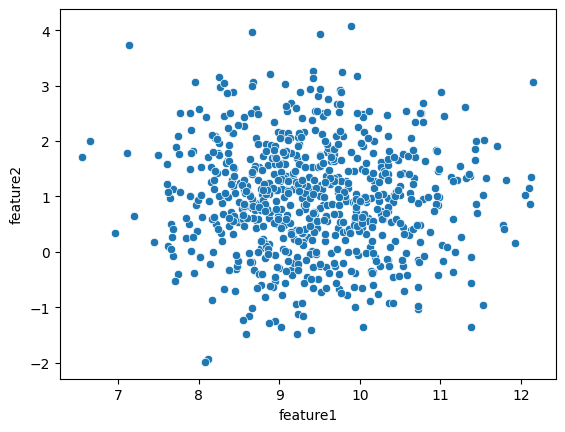

In [192]:
X, y = make_blobs(n_samples=700, 
                  n_features=2,
                  centers=1,
                  cluster_std=1,
                  random_state=4   
                )
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1] })
sns.scatterplot(data=df, x="feature1", y="feature2")
plt.show()

In [193]:
# check dataframe
df

,feature1,feature2
0,10.171043,1.276023
1,8.536107,0.777192
2,9.724446,0.422714
3,8.688757,1.478298
4,8.937727,1.402551
...,...,...
695,8.386344,2.500617
696,10.719016,-0.985150
697,9.195350,1.452718
698,8.230171,2.035682


# Descriptive Analytics

Check the generated dataframe to quickly identify anomalies.

In [194]:
df.describe(percentiles=[0.10,0.25,0.30,0.50,0.75,0.80,0.90]).T

,count,mean,std,min,10%,25%,30%,50%,75%,80%,90%,max
feature1,700.0,9.411384,0.955847,6.552688,8.242629,8.743283,8.872782,9.354551,10.051824,10.227176,10.668660,12.153472
feature2,700.0,0.965603,1.001734,-1.987272,-0.342789,0.326398,0.475788,0.999505,1.634605,1.781435,2.228027,4.078683


Plot features

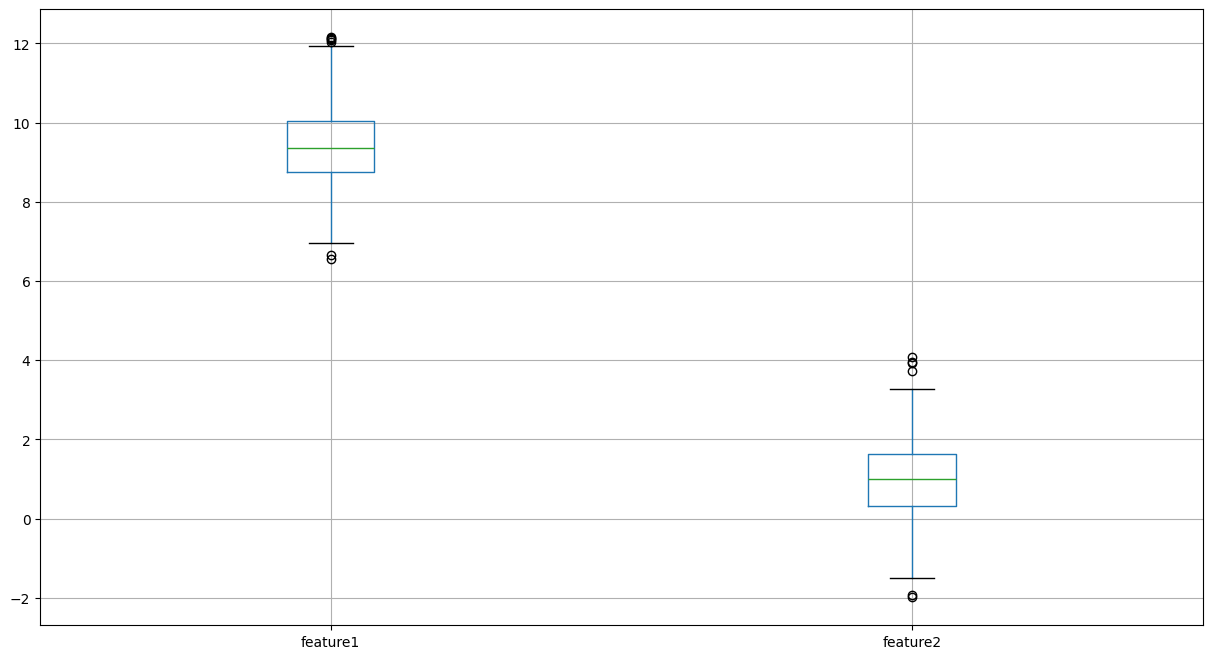

In [195]:
df.boxplot(figsize=(15,8))
plt.show()


Prepare data for the training process

In [196]:
scaled_df=scale_dataframe(df)
scaled_df

,feature1,feature2
0,0.646044,0.537969
1,0.354132,0.455734
2,0.566306,0.397297
3,0.381387,0.571315
4,0.425840,0.558828
...,...,...
695,0.327393,0.739849
696,0.743883,0.165204
697,0.471838,0.567098
698,0.299509,0.663202


## Train Process

Set the random_state to any integer for reproducibility

In [197]:
clf = IsolationForest(n_estimators=100,
                      max_samples=256,
                      contamination=0.05,
                      max_features=2,
                      bootstrap=True,
                      n_jobs=-1,
                      warm_start=False,
                      random_state=1
                      
                      ).fit(scaled_df)

Generate output with trained model

In [198]:
scored=clf.score_samples(scaled_df)
label=clf.predict(scaled_df)

In [199]:
new_df2=df.copy()

Assign the outputs to the original dataframe

In [200]:
new_df2['scored']=scored
new_df2['label']=label
new_df2['label']=np.where(new_df2['label']==-1,1,0)
new_df2

,feature1,feature2,scored,label
0,10.171043,1.276023,-0.447840,0
1,8.536107,0.777192,-0.440081,0
2,9.724446,0.422714,-0.434629,0
3,8.688757,1.478298,-0.432952,0
4,8.937727,1.402551,-0.425113,0
...,...,...,...,...
695,8.386344,2.500617,-0.513934,0
696,10.719016,-0.985150,-0.611240,1
697,9.195350,1.452718,-0.426449,0
698,8.230171,2.035682,-0.488792,0


how may anomalies were detected:

In [201]:
new_df2['label'].value_counts()

label
0    665
1     35
Name: count, dtype: int64

Let's perform a distribution analysis of the "scored" variable to understand the behavior

In [202]:
new_df2['scored'].describe(percentiles=[0.10,0.25,0.30,0.50,0.75,0.80,0.90]).T

count    700.000000
mean      -0.479721
std        0.058556
min       -0.740018
10%       -0.568528
25%       -0.506824
30%       -0.495712
50%       -0.456814
75%       -0.435569
80%       -0.432830
90%       -0.427509
max       -0.414029
Name: scored, dtype: float64

These percentiles give us insight into the distribution of the data:

        - 10th percentile: 10% of the data points are below -0.56.
        - 25th percentile (First quartile): 25% of the data points are below -0.50.
        - 30th percentile: 30% of the data points are below -0.49.
        - 50th percentile (Median): 50% of the data points are below -0.45
        - 75th percentile (Third quartile): 75% of the data points are below -0.43.
        - 80th percentile: 80% of the data points are below -0.43.
        - 90th percentile: 90% of the data points are below -0.42.

Maximum (max): The largest value in the dataset is -0.414029. This is the highest observed value, indicating the upper bound of the data.

Identifying Anomalies

Since anomalies are considered as smaller values in this context, we can identify them using the lower percentiles. Anomalies can be defined as data points that fall below a certain threshold. Based on the given summary, an appropriate threshold might be below the 10th percentile or even the minimum value if we want to be more conservative.

For instance:

Using the 10th percentile: Values below -0.568528 can be considered anomalies.
Using the minimum value: Values close to the minimum of -0.740018 are certainly anomalies.

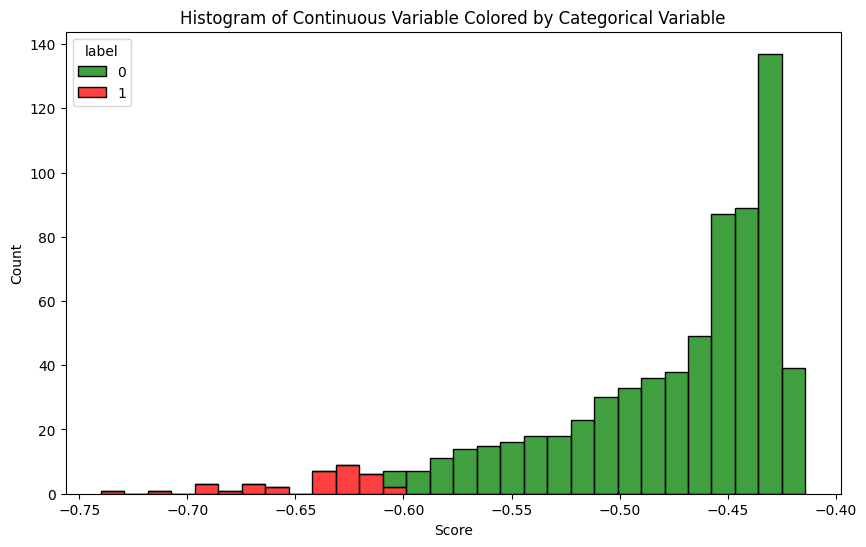

In [203]:
# Plotting
custom_palette = {1: 'red', 0: 'green'}
plt.figure(figsize=(10, 6))
sns.histplot(data=new_df2, x='scored', hue='label', multiple='stack', palette=custom_palette,bins=30)
plt.title('Histogram of Continuous Variable Colored by Categorical Variable')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

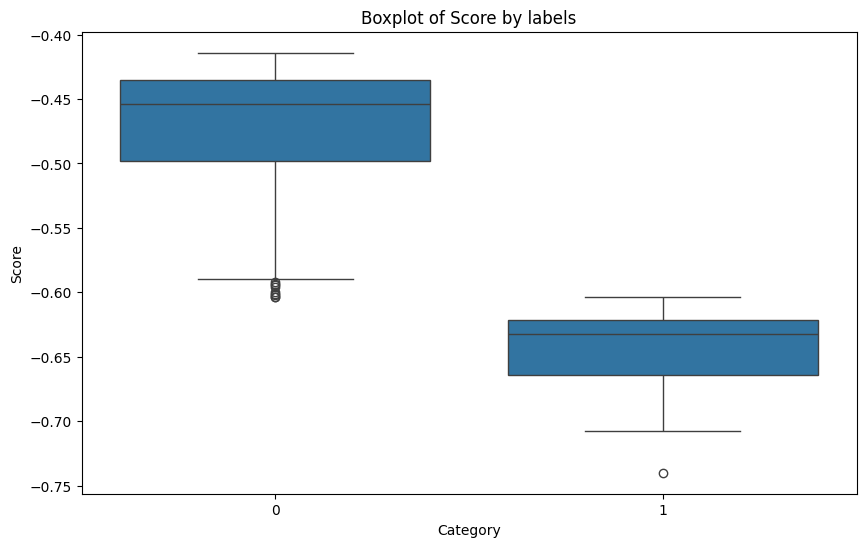

In [204]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=new_df2, x='label', y='scored')
plt.title('Boxplot of Score by labels')
plt.xlabel('Category')
plt.ylabel('Score')
plt.show()


label 0: normal data
label 1: anomaly

## Find the best number of cluster

Now we can create groups using the score variable with K-Means. First, we need to determine the optimal number of clusters using the elbow method.

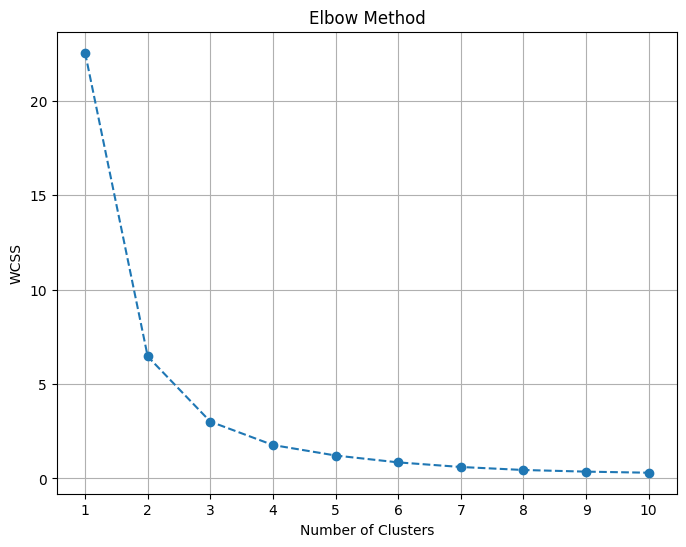

In [205]:
score_scaled=scale_column(new_df2,'scored')
wcss_values = calculate_wcss(score_scaled)
# Plot the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss_values, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

The best number of cluster in this case is 3 or maybe 4

# Generate cluster K-means

Now let's train the model and perform the clustering.

In [206]:
# Train KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42,n_init=10)
kmeans.fit(score_scaled.reshape(-1,1))

# Predict clusters for the data points
labels = kmeans.labels_

## Create new column with cluters group

In [207]:
new_df2['cluster']=labels
new_df2

,feature1,feature2,scored,label,cluster
0,10.171043,1.276023,-0.447840,0,0
1,8.536107,0.777192,-0.440081,0,0
2,9.724446,0.422714,-0.434629,0,0
3,8.688757,1.478298,-0.432952,0,0
4,8.937727,1.402551,-0.425113,0,0
...,...,...,...,...,...
695,8.386344,2.500617,-0.513934,0,1
696,10.719016,-0.985150,-0.611240,1,2
697,9.195350,1.452718,-0.426449,0,0
698,8.230171,2.035682,-0.488792,0,1


# Plot Result

The score is very useful for identifying anomalies with high, medium, or low probability. Note that we can change the contamination parameter multiple times without affecting the score variable.

As you can see, we are using not only Isolation Forest but also K-Means to create groups of risk and here is the output:

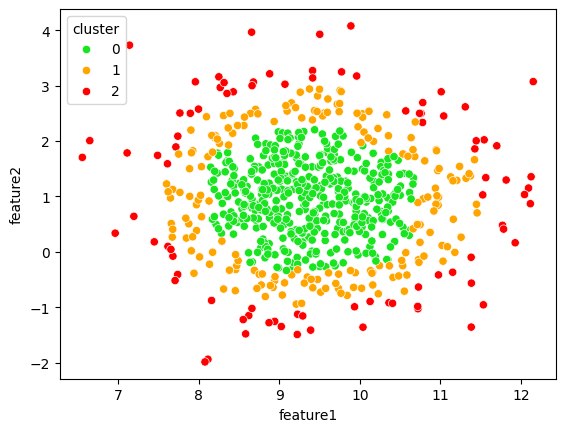

In [212]:
custom_palette = ["#19e420","#FFA500", "#FF0000"]
sns.scatterplot(data=new_df2, x="feature1", y="feature2",hue="cluster",palette=custom_palette)
plt.show()

# Conclusion

* The parameter contamination doest'n matter if we only use the score instead of label

* We can combine other algorithms, such as K-means, to create risk groups.

* the paramer max_samples=n, is strongly recommended to avoid swamping and masking.

* This algorithm performs well in high-dimensional data

